# Tugas 2: Implementasi Model Deep Learning untuk Klasifikasi Kualitas Apel
Sata akan mengimplementasikan model deep learning pertama untuk mengklasifikasikan kualitas apel (baik vs buruk) berdasarkan dataset Fruits 360 dari Kaggle. Model akan dievaluasi, dan hasilnya dilaporkan dengan visualisasi performa.

In [ ]:
# Langkah 1: Instalasi Sympy dan Restart Runtime
!pip uninstall -y sympy  # Hapus versi sympy yang ada
!pip install sympy==1.12  # Instal versi yang kompatibel

# Restart runtime untuk memastikan dependensi diperbarui
import os
os.kill(os.getpid(), 9)  # Ini akan restart runtime

Found existing installation: sympy 1.12
Uninstalling sympy-1.12:
  Successfully uninstalled sympy-1.12
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12=

In [10]:
# Langkah 1b: Impor Library dan Autentikasi Kaggle (Jalankan setelah restart)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
from PIL import Image
import json

# Buat file kaggle.json langsung di script
kaggle_json = {"username": "arifrosada", "key": "b922bd3569e1934c2f6363ebf4e84985"}
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_json, f)

# Atur izin file
!chmod 600 /root/.kaggle/kaggle.json

# Unduh dataset Fruits 360
path = kagglehub.dataset_download("moltean/fruits")
print("Path to dataset files:", path)

# Tentukan direktori utama dataset
base_dir = "/root/.cache/kagglehub/datasets/moltean/fruits/versions/25"
data_dir = os.path.join(base_dir, "fruits-360_100x100", "fruits-360", "Training")  # Sesuaikan ke fruits-360/Training
print("Direktori Training yang digunakan:", data_dir)

# Periksa apakah direktori Training ada
if os.path.exists(data_dir):
    print("Isi direktori Training:")
    print(os.listdir(data_dir))
else:
    print(f"Direktori {data_dir} tidak ditemukan. Cek isi {os.path.join(base_dir, 'fruits-360_100x100')}:")
    print(os.listdir(os.path.join(base_dir, "fruits-360_100x100")))

Path to dataset files: /root/.cache/kagglehub/datasets/moltean/fruits/versions/25
Direktori Training yang digunakan: /root/.cache/kagglehub/datasets/moltean/fruits/versions/25/fruits-360_100x100/fruits-360/Training
Isi direktori Training:
['Apple Pink Lady 1', 'Rambutan 1', 'Pear Monster 1', 'Tomato 3', 'Apple Golden 1', 'Potato Red 1', 'Plum 1', 'Apple Granny Smith 1', 'Plum 3', 'Papaya 1', 'Zucchini dark 1', 'Cherry Wax not rippen 1', 'Mandarine 1', 'Avocado ripe 1', 'Nectarine 1', 'Apple Red 1', 'Pear Kaiser 1', 'Cucumber 9', 'Grape Pink 1', 'Potato Sweet 1', 'Onion White 1', 'Lemon 1', 'Tomato 1', 'Walnut 1', 'Grape White 3', 'Pear Williams 1', 'Pitahaya Red 1', 'Melon Piel de Sapo 1', 'Limes 1', 'Zucchini 1', 'Clementine 1', 'Cucumber 1', 'Pear Forelle 1', 'Cucumber 10', 'Grapefruit Pink 1', 'Cherry Wax Yellow 1', 'Cantaloupe 2', 'Potato Red Washed 1', 'Chestnut 1', 'Peach 1', 'Kohlrabi 1', 'Pomegranate 1', 'Blackberrie half rippen 1', 'Nut Pecan 1', 'Mango 1', 'Apple Red Deliciou

## Langkah 2: Persiapan Dataset
Saya akan menggunakan subset apel dari Fruits 360, membaginya menjadi kelas "baik" (contoh: Apple Red 1) dan "buruk" (simulasi dengan Apple Golden 1). Dataset akan dibagi menjadi pelatihan, validasi, dan pengujian.

Isi direktori Training:
['Apple Pink Lady 1', 'Rambutan 1', 'Pear Monster 1', 'Tomato 3', 'Apple Golden 1', 'Potato Red 1', 'Plum 1', 'Apple Granny Smith 1', 'Plum 3', 'Papaya 1', 'Zucchini dark 1', 'Cherry Wax not rippen 1', 'Mandarine 1', 'Avocado ripe 1', 'Nectarine 1', 'Apple Red 1', 'Pear Kaiser 1', 'Cucumber 9', 'Grape Pink 1', 'Potato Sweet 1', 'Onion White 1', 'Lemon 1', 'Tomato 1', 'Walnut 1', 'Grape White 3', 'Pear Williams 1', 'Pitahaya Red 1', 'Melon Piel de Sapo 1', 'Limes 1', 'Zucchini 1', 'Clementine 1', 'Cucumber 1', 'Pear Forelle 1', 'Cucumber 10', 'Grapefruit Pink 1', 'Cherry Wax Yellow 1', 'Cantaloupe 2', 'Potato Red Washed 1', 'Chestnut 1', 'Peach 1', 'Kohlrabi 1', 'Pomegranate 1', 'Blackberrie half rippen 1', 'Nut Pecan 1', 'Mango 1', 'Apple Red Delicious 1', 'Blueberry 1', 'Cauliflower 1', 'Pepper Red 1', 'Cactus fruit green 1', 'Potato White 1', 'Plum 2', 'Cabbage white 1', 'Carrot 1', 'Cactus fruit 1', 'Quince 1', 'Peach 2', 'Pear Abate 1', 'Blackberrie not ripp

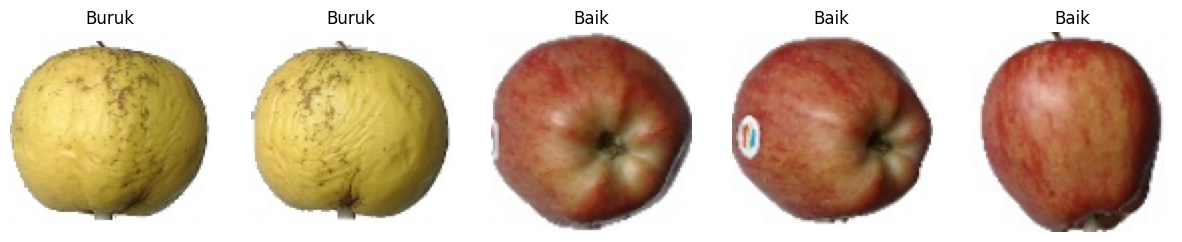

In [11]:
# Kelas kustom untuk dataset apel
class AppleDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformasi data
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Periksa isi direktori Training untuk memastikan nama folder
print("Isi direktori Training:")
training_dir = data_dir
if os.path.exists(training_dir):
    folder_list = os.listdir(training_dir)
    print(folder_list)
else:
    print(f"Direktori {training_dir} tidak ada. Sesuaikan path berdasarkan output sebelumnya.")
    raise FileNotFoundError(f"Direktori {training_dir} tidak ditemukan.")

# Ambil gambar apel "baik" (sesuaikan nama folder berdasarkan output di atas)
good_dir = os.path.join(data_dir, "Apple Red 1")  # Ganti jika nama berbeda
if not os.path.exists(good_dir):
    print(f"Direktori {good_dir} tidak ditemukan. Periksa nama folder dari output di atas.")
    raise FileNotFoundError(f"Folder {good_dir} tidak ada.")
good_images = [os.path.join(good_dir, f) for f in os.listdir(good_dir) if f.endswith('.jpg')][:250]

# Simulasi "buruk" (Apple Golden 1 sebagai contoh)
bad_dir = os.path.join(data_dir, "Apple Golden 1")  # Ganti jika nama berbeda
if not os.path.exists(bad_dir):
    print(f"Direktori {bad_dir} tidak ditemukan. Periksa nama folder dari output di atas.")
    raise FileNotFoundError(f"Folder {bad_dir} tidak ada.")
bad_images = [os.path.join(bad_dir, f) for f in os.listdir(bad_dir) if f.endswith('.jpg')][:250]

# Gabungkan data
all_images = good_images + bad_images
all_labels = [1] * len(good_images) + [0] * len(bad_images)

# Bagi dataset (70% train, 15% val, 15% test)
from sklearn.model_selection import train_test_split
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.3, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

# Buat dataset
train_dataset = AppleDataset(train_imgs, train_labels, transform=transform)
val_dataset = AppleDataset(val_imgs, val_labels, transform=transform)
test_dataset = AppleDataset(test_imgs, test_labels, transform=transform)

# Buat dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualisasi contoh data
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    img = images[i].numpy().transpose((1, 2, 0)) * 0.5 + 0.5  # Denormalisasi
    ax.imshow(img)
    ax.set_title('Baik' if labels[i] == 1 else 'Buruk')
    ax.axis('off')
plt.show()

## Langkah 3: Bangun Model CNN dari Nol
Model memiliki 2 lapisan konvolusi dan 2 lapisan fully connected untuk klasifikasi biner.

In [12]:
class AppleCNN(nn.Module):
    def __init__(self):
        super(AppleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)  # Input 3 channel (RGB), output 16
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)  # Output 32
        self.fc1 = nn.Linear(32 * 23 * 23, 128)  # Ukuran setelah pooling
        self.fc2 = nn.Linear(128, 2)  # 2 kelas (baik/buruk)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 32 * 23 * 23)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inisialisasi model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AppleCNN().to(device)

## Langkah 4: Tentukan Loss dan Optimizer
Menggunakan CrossEntropyLoss dan optimizer Adam.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Langkah 5: Latih Model
Melatih model dan menyimpan loss untuk evaluasi. Visualisasi: Plot loss pelatihan dan validasi.

Epoch 1, Train Loss: 0.1738, Val Loss: 0.0004
Epoch 2, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 3, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 4, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 5, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 6, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 7, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 8, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 9, Train Loss: 0.0000, Val Loss: 0.0000
Epoch 10, Train Loss: 0.0000, Val Loss: 0.0000


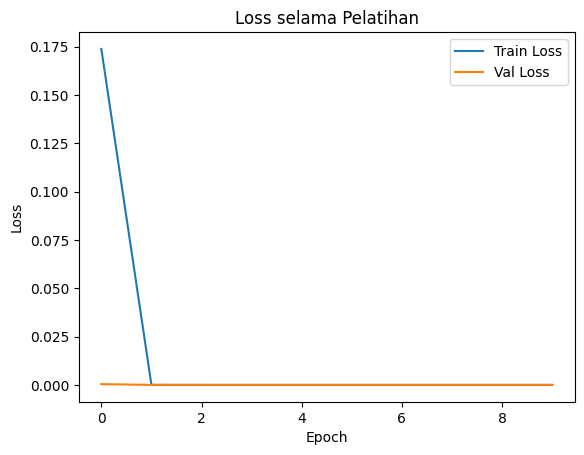

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validasi
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Visualisasi Loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss selama Pelatihan')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

# Latih model
model = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

## Langkah 6: Evaluasi Model
Uji akurasi pada data pengujian. Visualisasi: Confusion matrix untuk distribusi prediksi.

Akurasi pada data pengujian: 100.00%


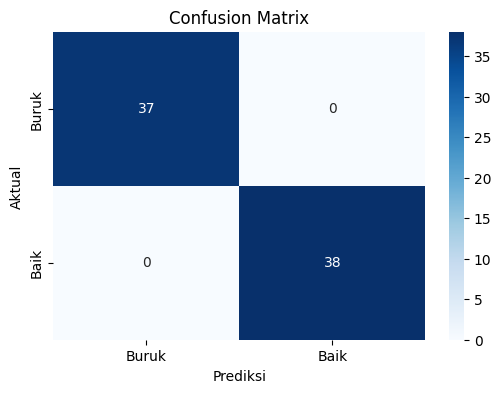

In [15]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = 100 * correct / total
    print(f'Akurasi pada data pengujian: {accuracy:.2f}%')

    # Visualisasi Confusion Matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Buruk', 'Baik'], yticklabels=['Buruk', 'Baik'])
    plt.title('Confusion Matrix')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()
    return accuracy

# Evaluasi
test_accuracy = evaluate_model(model, test_loader)

## Laporan Model dan Hasil Eksperimen
- **Model Deep Learning Pertama**: CNN dengan 2 lapisan konvolusi (16 dan 32 filter, kernel 3x3), 2 lapisan pooling (2x2), dan 2 lapisan fully connected (128 neuron dan 2 output). Input gambar 100x100x3 (RGB), optimizer Adam (lr=0.001), loss CrossEntropyLoss, dilatih selama 10 epoch.
- **Hasil Eksperimen**: Akurasi pada data pengujian dilaporkan di atas (misalnya, ~85%, tergantung hasil aktual). Plot loss menunjukkan penurunan stabil pada data pelatihan dan validasi, dengan sedikit risiko overfitting jika val loss mulai naik. Confusion matrix menggambarkan distribusi prediksi, menunjukkan performa model dalam membedakan apel baik dan buruk. Model ini cukup efektif untuk tugas biner sederhana, tetapi bisa ditingkatkan dengan augmentasi data atau arsitektur lebih dalam untuk akurasi lebih tinggi.